In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment
from BackGround_modules.Class_4_Create_Sample_Classification_instancs import Make_Sample_Classification

##### Define_Basic_Parameters

In [31]:
# define the year_name for test, here choose these years because they represent
# Landsat8/7/5 respectively
year_name = ['2017_2019','2011_2013', '2008_2010']
percent_value = [1,2,3,5,7,10,20,30,50,70,100]
tree_num = [1] + list(range(10,121,10))

combination_name = [ 'Landsat',
                     'Fourier',
                     'Landsat_Fourier',
                     'Landsat_Mean',
                     'Fourier_Mean',
                     'Landsat_Fourier_Mean']

##### Part_1: Calculate the band_combination accuracy for [verified_points ] and [Zone_sample_diff_percent]

Produce classification_instances <br>
NOTE: Here only perform percentage reduction on zone_sample

In [ ]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# instantiate the combo_instance dictionary
Combo_instance = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    Verified_sample = ee.FeatureCollection(f'{path}/Verified_point_{year}_extract_Landsat_Fourier_Normalized_img')
    Zone_sample     = ee.FeatureCollection(f'{path}/Zone_point_{year}_extract_Landsat_Fourier_Normalized_img')
    
    for pct in percent_value:
        Subset_zone_sample  = Make_Sample_Classification.Step_1_Subset_sample(Zone_sample,pct)
        # Merge Verified_points with Zone_points
        Verified_merge_Zone = Subset_zone_sample.merge(Verified_sample)
        Band_combo          = Make_Sample_Classification.Step_2_Create_Band_Combo(Verified_merge_Zone)
        
        for combo in Band_combo:
            Accuracy_instance = Make_Sample_Classification.Step_3_Create_Classification_Instance(year,Verified_merge_Zone,
                                                                                                 combo,tree_num,pct,
                                                                                                classificaiton_func = Classification ) 
            Combo_instance.update(Accuracy_instance)
        

Compute the accuracy and unpack the accuracy value

In [ ]:
# innitialize the accuracy dict
Combo_acc = {}

# innitilize operation flag to report the process
Opts_flat  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_value) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_value:
            for tree in tree_num:

                Opts_flat+=1

                Combo_acc[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flat:04}/{Opts_tatal}')
            print('_________________')

In [10]:
# # convert the accuracy dicionary into a dataframe
# Combo_acc_df = pd.DataFrame(Combo_acc).T
# Combo_acc_df.index.names = ['Year','Combo','Percent','Tree']

# # save the dataframe
# Combo_acc_df.to_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')

##### Part_2: Calculate the band_combination accuracy for [verified_points ] and [Village_point_1990_1992] with different percentage reduction

Produce classification_instances

In [19]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# instantiate the combo_instance dictionary
Combo_instance_with_village = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    # import samples
    Invarient_built = ee.FeatureCollection(f'{path}/Invarient_built_{year}')
    Invarient_non_Built  = ee.FeatureCollection(f'{path}/Invarient_non_built_{year}')
    
    # make sure they are the same size.
    min_size = min(Invarient_built.size().getInfo(),Invarient_non_Built.size().getInfo())
    Invarient_built = Invarient_built.randomColumn('z', 101).limit(min_size,'z')
    Invarient_non_Built  = Invarient_non_Built.randomColumn('z', 101).limit(min_size,'z')
    
    for pct in percent_value:
        
        # Create percentage_reduced samples, only use non-built points from verified points
        Subset_Invarient_built  = Make_Sample_Classification.Step_1_Subset_sample(Invarient_built,pct)
        Subset_Invarient_non_Built   = Make_Sample_Classification.Step_1_Subset_sample(Invarient_non_Built,pct)
        
        # Merge Verified_points with Zone_points
        Sample_merge = Subset_Invarient_built.merge(Subset_Invarient_non_Built)
        
        # Get the band_combo names
        Band_combo   = Make_Sample_Classification.Step_2_Create_Band_Combo(Sample_merge)
        
        for combo in Band_combo:
            Accuracy_instance = Make_Sample_Classification.\
                                Step_3_Create_Classification_Instance(year,Sample_merge,
                                                                      combo,tree_num,
                                                                      pct,classificaiton_func = Classification ) 
            Combo_instance_with_village.update(Accuracy_instance)
        

Percetage coresponded size is 87
Percetage coresponded size is 87
Classification of 2017_2019_Landsat_pct_001_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_001_tree_0001 completed!
Classification of 2017_2

Percetage coresponded size is 262
Percetage coresponded size is 262
Classification of 2017_2019_Landsat_pct_003_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_003_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 612
Percetage coresponded size is 612
Classification of 2017_2019_Landsat_pct_007_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_007_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 1750
Percetage coresponded size is 1750
Classification of 2017_2019_Landsat_pct_020_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_020_tree_0001 completed!
Classification of 20

Percetage coresponded size is 4376
Percetage coresponded size is 4376
Classification of 2017_2019_Landsat_pct_050_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 8753
Percetage coresponded size is 8753
Classification of 2017_2019_Landsat_pct_100_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_100_tree_0001 completed!
Classification of 20

Percetage coresponded size is 175
Percetage coresponded size is 175
Classification of 2011_2013_Landsat_pct_002_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 437
Percetage coresponded size is 437
Classification of 2011_2013_Landsat_pct_005_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 875
Percetage coresponded size is 875
Classification of 2011_2013_Landsat_pct_010_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 2625
Percetage coresponded size is 2625
Classification of 2011_2013_Landsat_pct_030_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 6127
Percetage coresponded size is 6127
Classification of 2011_2013_Landsat_pct_070_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 87
Percetage coresponded size is 87
Classification of 2008_2010_Landsat_pct_001_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_001_tree_0001 completed!
Classification of 2008_2

Percetage coresponded size is 262
Percetage coresponded size is 262
Classification of 2008_2010_Landsat_pct_003_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_003_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 612
Percetage coresponded size is 612
Classification of 2008_2010_Landsat_pct_007_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_007_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 1750
Percetage coresponded size is 1750
Classification of 2008_2010_Landsat_pct_020_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_020_tree_0001 completed!
Classification of 20

Percetage coresponded size is 4376
Percetage coresponded size is 4376
Classification of 2008_2010_Landsat_pct_050_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 8753
Percetage coresponded size is 8753
Classification of 2008_2010_Landsat_pct_100_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_100_tree_0001 completed!
Classification of 20

Produce classification_instances <br>
NOTE: Here only perform percentage reduction BOTH on  Verified_sample and Village_Sample

In [34]:
# innitialize the accuracy dict
Combo_acc_with_village = {}

# innitilize operation flag to report the process
Opts_flat  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_value) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_value:
            for tree in tree_num:

                Opts_flat+=1

                Combo_acc_with_village[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance_with_village[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flat:04}/{Opts_tatal}')
            print('_________________')

2017_2019_Landsat_pct_001_tree_001 accuracy computation finished! ==>0001/2574
2017_2019_Landsat_pct_001_tree_010 accuracy computation finished! ==>0002/2574
2017_2019_Landsat_pct_001_tree_020 accuracy computation finished! ==>0003/2574
2017_2019_Landsat_pct_001_tree_030 accuracy computation finished! ==>0004/2574
2017_2019_Landsat_pct_001_tree_040 accuracy computation finished! ==>0005/2574
2017_2019_Landsat_pct_001_tree_050 accuracy computation finished! ==>0006/2574
2017_2019_Landsat_pct_001_tree_060 accuracy computation finished! ==>0007/2574
2017_2019_Landsat_pct_001_tree_070 accuracy computation finished! ==>0008/2574
2017_2019_Landsat_pct_001_tree_080 accuracy computation finished! ==>0009/2574
2017_2019_Landsat_pct_001_tree_090 accuracy computation finished! ==>0010/2574
2017_2019_Landsat_pct_001_tree_100 accuracy computation finished! ==>0011/2574
2017_2019_Landsat_pct_001_tree_110 accuracy computation finished! ==>0012/2574
2017_2019_Landsat_pct_001_tree_120 accuracy computat

2017_2019_Landsat_pct_030_tree_120 accuracy computation finished! ==>0104/2574
_________________
2017_2019_Landsat_pct_050_tree_001 accuracy computation finished! ==>0105/2574
2017_2019_Landsat_pct_050_tree_010 accuracy computation finished! ==>0106/2574
2017_2019_Landsat_pct_050_tree_020 accuracy computation finished! ==>0107/2574
2017_2019_Landsat_pct_050_tree_030 accuracy computation finished! ==>0108/2574
2017_2019_Landsat_pct_050_tree_040 accuracy computation finished! ==>0109/2574
2017_2019_Landsat_pct_050_tree_050 accuracy computation finished! ==>0110/2574
2017_2019_Landsat_pct_050_tree_060 accuracy computation finished! ==>0111/2574
2017_2019_Landsat_pct_050_tree_070 accuracy computation finished! ==>0112/2574
2017_2019_Landsat_pct_050_tree_080 accuracy computation finished! ==>0113/2574
2017_2019_Landsat_pct_050_tree_090 accuracy computation finished! ==>0114/2574
2017_2019_Landsat_pct_050_tree_100 accuracy computation finished! ==>0115/2574
2017_2019_Landsat_pct_050_tree_110

2017_2019_Fourier_pct_007_tree_100 accuracy computation finished! ==>0206/2574
2017_2019_Fourier_pct_007_tree_110 accuracy computation finished! ==>0207/2574
2017_2019_Fourier_pct_007_tree_120 accuracy computation finished! ==>0208/2574
_________________
2017_2019_Fourier_pct_010_tree_001 accuracy computation finished! ==>0209/2574
2017_2019_Fourier_pct_010_tree_010 accuracy computation finished! ==>0210/2574
2017_2019_Fourier_pct_010_tree_020 accuracy computation finished! ==>0211/2574
2017_2019_Fourier_pct_010_tree_030 accuracy computation finished! ==>0212/2574
2017_2019_Fourier_pct_010_tree_040 accuracy computation finished! ==>0213/2574
2017_2019_Fourier_pct_010_tree_050 accuracy computation finished! ==>0214/2574
2017_2019_Fourier_pct_010_tree_060 accuracy computation finished! ==>0215/2574
2017_2019_Fourier_pct_010_tree_070 accuracy computation finished! ==>0216/2574
2017_2019_Fourier_pct_010_tree_080 accuracy computation finished! ==>0217/2574
2017_2019_Fourier_pct_010_tree_090

2017_2019_Landsat_Fourier_pct_002_tree_060 accuracy computation finished! ==>0306/2574
2017_2019_Landsat_Fourier_pct_002_tree_070 accuracy computation finished! ==>0307/2574
2017_2019_Landsat_Fourier_pct_002_tree_080 accuracy computation finished! ==>0308/2574
2017_2019_Landsat_Fourier_pct_002_tree_090 accuracy computation finished! ==>0309/2574
2017_2019_Landsat_Fourier_pct_002_tree_100 accuracy computation finished! ==>0310/2574
2017_2019_Landsat_Fourier_pct_002_tree_110 accuracy computation finished! ==>0311/2574
2017_2019_Landsat_Fourier_pct_002_tree_120 accuracy computation finished! ==>0312/2574
_________________
2017_2019_Landsat_Fourier_pct_003_tree_001 accuracy computation finished! ==>0313/2574
2017_2019_Landsat_Fourier_pct_003_tree_010 accuracy computation finished! ==>0314/2574
2017_2019_Landsat_Fourier_pct_003_tree_020 accuracy computation finished! ==>0315/2574
2017_2019_Landsat_Fourier_pct_003_tree_030 accuracy computation finished! ==>0316/2574
2017_2019_Landsat_Fourier

2017_2019_Landsat_Fourier_pct_050_tree_080 accuracy computation finished! ==>0399/2574
2017_2019_Landsat_Fourier_pct_050_tree_090 accuracy computation finished! ==>0400/2574
2017_2019_Landsat_Fourier_pct_050_tree_100 accuracy computation finished! ==>0401/2574
2017_2019_Landsat_Fourier_pct_050_tree_110 accuracy computation finished! ==>0402/2574
2017_2019_Landsat_Fourier_pct_050_tree_120 accuracy computation finished! ==>0403/2574
_________________
2017_2019_Landsat_Fourier_pct_070_tree_001 accuracy computation finished! ==>0404/2574
2017_2019_Landsat_Fourier_pct_070_tree_010 accuracy computation finished! ==>0405/2574
2017_2019_Landsat_Fourier_pct_070_tree_020 accuracy computation finished! ==>0406/2574
2017_2019_Landsat_Fourier_pct_070_tree_030 accuracy computation finished! ==>0407/2574
2017_2019_Landsat_Fourier_pct_070_tree_040 accuracy computation finished! ==>0408/2574
2017_2019_Landsat_Fourier_pct_070_tree_050 accuracy computation finished! ==>0409/2574
2017_2019_Landsat_Fourier

2017_2019_Landsat_Mean_pct_007_tree_120 accuracy computation finished! ==>0494/2574
_________________
2017_2019_Landsat_Mean_pct_010_tree_001 accuracy computation finished! ==>0495/2574
2017_2019_Landsat_Mean_pct_010_tree_010 accuracy computation finished! ==>0496/2574
2017_2019_Landsat_Mean_pct_010_tree_020 accuracy computation finished! ==>0497/2574
2017_2019_Landsat_Mean_pct_010_tree_030 accuracy computation finished! ==>0498/2574
2017_2019_Landsat_Mean_pct_010_tree_040 accuracy computation finished! ==>0499/2574
2017_2019_Landsat_Mean_pct_010_tree_050 accuracy computation finished! ==>0500/2574
2017_2019_Landsat_Mean_pct_010_tree_060 accuracy computation finished! ==>0501/2574
2017_2019_Landsat_Mean_pct_010_tree_070 accuracy computation finished! ==>0502/2574
2017_2019_Landsat_Mean_pct_010_tree_080 accuracy computation finished! ==>0503/2574
2017_2019_Landsat_Mean_pct_010_tree_090 accuracy computation finished! ==>0504/2574
2017_2019_Landsat_Mean_pct_010_tree_100 accuracy computati

2017_2019_Fourier_Mean_pct_002_tree_040 accuracy computation finished! ==>0590/2574
2017_2019_Fourier_Mean_pct_002_tree_050 accuracy computation finished! ==>0591/2574
2017_2019_Fourier_Mean_pct_002_tree_060 accuracy computation finished! ==>0592/2574
2017_2019_Fourier_Mean_pct_002_tree_070 accuracy computation finished! ==>0593/2574
2017_2019_Fourier_Mean_pct_002_tree_080 accuracy computation finished! ==>0594/2574
2017_2019_Fourier_Mean_pct_002_tree_090 accuracy computation finished! ==>0595/2574
2017_2019_Fourier_Mean_pct_002_tree_100 accuracy computation finished! ==>0596/2574
2017_2019_Fourier_Mean_pct_002_tree_110 accuracy computation finished! ==>0597/2574
2017_2019_Fourier_Mean_pct_002_tree_120 accuracy computation finished! ==>0598/2574
_________________
2017_2019_Fourier_Mean_pct_003_tree_001 accuracy computation finished! ==>0599/2574
2017_2019_Fourier_Mean_pct_003_tree_010 accuracy computation finished! ==>0600/2574
2017_2019_Fourier_Mean_pct_003_tree_020 accuracy computati

2017_2019_Fourier_Mean_pct_050_tree_100 accuracy computation finished! ==>0687/2574
2017_2019_Fourier_Mean_pct_050_tree_110 accuracy computation finished! ==>0688/2574
2017_2019_Fourier_Mean_pct_050_tree_120 accuracy computation finished! ==>0689/2574
_________________
2017_2019_Fourier_Mean_pct_070_tree_001 accuracy computation finished! ==>0690/2574
2017_2019_Fourier_Mean_pct_070_tree_010 accuracy computation finished! ==>0691/2574
2017_2019_Fourier_Mean_pct_070_tree_020 accuracy computation finished! ==>0692/2574
2017_2019_Fourier_Mean_pct_070_tree_030 accuracy computation finished! ==>0693/2574
2017_2019_Fourier_Mean_pct_070_tree_040 accuracy computation finished! ==>0694/2574
2017_2019_Fourier_Mean_pct_070_tree_050 accuracy computation finished! ==>0695/2574
2017_2019_Fourier_Mean_pct_070_tree_060 accuracy computation finished! ==>0696/2574
2017_2019_Fourier_Mean_pct_070_tree_070 accuracy computation finished! ==>0697/2574
2017_2019_Fourier_Mean_pct_070_tree_080 accuracy computati

2017_2019_Landsat_Fourier_Mean_pct_007_tree_100 accuracy computation finished! ==>0778/2574
2017_2019_Landsat_Fourier_Mean_pct_007_tree_110 accuracy computation finished! ==>0779/2574
2017_2019_Landsat_Fourier_Mean_pct_007_tree_120 accuracy computation finished! ==>0780/2574
_________________
2017_2019_Landsat_Fourier_Mean_pct_010_tree_001 accuracy computation finished! ==>0781/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_010 accuracy computation finished! ==>0782/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_020 accuracy computation finished! ==>0783/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_030 accuracy computation finished! ==>0784/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_040 accuracy computation finished! ==>0785/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_050 accuracy computation finished! ==>0786/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_060 accuracy computation finished! ==>0787/2574
2017_2019_Landsat_Fourier_Mean_pct_010_tree_070 accuracy compu

2011_2013_Landsat_pct_001_tree_080 accuracy computation finished! ==>0867/2574
2011_2013_Landsat_pct_001_tree_090 accuracy computation finished! ==>0868/2574
2011_2013_Landsat_pct_001_tree_100 accuracy computation finished! ==>0869/2574
2011_2013_Landsat_pct_001_tree_110 accuracy computation finished! ==>0870/2574
2011_2013_Landsat_pct_001_tree_120 accuracy computation finished! ==>0871/2574
_________________
2011_2013_Landsat_pct_002_tree_001 accuracy computation finished! ==>0872/2574
2011_2013_Landsat_pct_002_tree_010 accuracy computation finished! ==>0873/2574
2011_2013_Landsat_pct_002_tree_020 accuracy computation finished! ==>0874/2574
2011_2013_Landsat_pct_002_tree_030 accuracy computation finished! ==>0875/2574
2011_2013_Landsat_pct_002_tree_040 accuracy computation finished! ==>0876/2574
2011_2013_Landsat_pct_002_tree_050 accuracy computation finished! ==>0877/2574
2011_2013_Landsat_pct_002_tree_060 accuracy computation finished! ==>0878/2574
2011_2013_Landsat_pct_002_tree_070

2011_2013_Landsat_pct_050_tree_060 accuracy computation finished! ==>0969/2574
2011_2013_Landsat_pct_050_tree_070 accuracy computation finished! ==>0970/2574
2011_2013_Landsat_pct_050_tree_080 accuracy computation finished! ==>0971/2574
2011_2013_Landsat_pct_050_tree_090 accuracy computation finished! ==>0972/2574
2011_2013_Landsat_pct_050_tree_100 accuracy computation finished! ==>0973/2574
2011_2013_Landsat_pct_050_tree_110 accuracy computation finished! ==>0974/2574
2011_2013_Landsat_pct_050_tree_120 accuracy computation finished! ==>0975/2574
_________________
2011_2013_Landsat_pct_070_tree_001 accuracy computation finished! ==>0976/2574
2011_2013_Landsat_pct_070_tree_010 accuracy computation finished! ==>0977/2574
2011_2013_Landsat_pct_070_tree_020 accuracy computation finished! ==>0978/2574
2011_2013_Landsat_pct_070_tree_030 accuracy computation finished! ==>0979/2574
2011_2013_Landsat_pct_070_tree_040 accuracy computation finished! ==>0980/2574
2011_2013_Landsat_pct_070_tree_050

2011_2013_Fourier_pct_010_tree_040 accuracy computation finished! ==>1071/2574
2011_2013_Fourier_pct_010_tree_050 accuracy computation finished! ==>1072/2574
2011_2013_Fourier_pct_010_tree_060 accuracy computation finished! ==>1073/2574
2011_2013_Fourier_pct_010_tree_070 accuracy computation finished! ==>1074/2574
2011_2013_Fourier_pct_010_tree_080 accuracy computation finished! ==>1075/2574
2011_2013_Fourier_pct_010_tree_090 accuracy computation finished! ==>1076/2574
2011_2013_Fourier_pct_010_tree_100 accuracy computation finished! ==>1077/2574
2011_2013_Fourier_pct_010_tree_110 accuracy computation finished! ==>1078/2574
2011_2013_Fourier_pct_010_tree_120 accuracy computation finished! ==>1079/2574
_________________
2011_2013_Fourier_pct_020_tree_001 accuracy computation finished! ==>1080/2574
2011_2013_Fourier_pct_020_tree_010 accuracy computation finished! ==>1081/2574
2011_2013_Fourier_pct_020_tree_020 accuracy computation finished! ==>1082/2574
2011_2013_Fourier_pct_020_tree_030

2011_2013_Landsat_Fourier_pct_003_tree_001 accuracy computation finished! ==>1171/2574
2011_2013_Landsat_Fourier_pct_003_tree_010 accuracy computation finished! ==>1172/2574
2011_2013_Landsat_Fourier_pct_003_tree_020 accuracy computation finished! ==>1173/2574
2011_2013_Landsat_Fourier_pct_003_tree_030 accuracy computation finished! ==>1174/2574
2011_2013_Landsat_Fourier_pct_003_tree_040 accuracy computation finished! ==>1175/2574
2011_2013_Landsat_Fourier_pct_003_tree_050 accuracy computation finished! ==>1176/2574
2011_2013_Landsat_Fourier_pct_003_tree_060 accuracy computation finished! ==>1177/2574
2011_2013_Landsat_Fourier_pct_003_tree_070 accuracy computation finished! ==>1178/2574
2011_2013_Landsat_Fourier_pct_003_tree_080 accuracy computation finished! ==>1179/2574
2011_2013_Landsat_Fourier_pct_003_tree_090 accuracy computation finished! ==>1180/2574
2011_2013_Landsat_Fourier_pct_003_tree_100 accuracy computation finished! ==>1181/2574
2011_2013_Landsat_Fourier_pct_003_tree_110 

2011_2013_Landsat_Fourier_pct_070_tree_020 accuracy computation finished! ==>1264/2574
2011_2013_Landsat_Fourier_pct_070_tree_030 accuracy computation finished! ==>1265/2574
2011_2013_Landsat_Fourier_pct_070_tree_040 accuracy computation finished! ==>1266/2574
2011_2013_Landsat_Fourier_pct_070_tree_050 accuracy computation finished! ==>1267/2574
2011_2013_Landsat_Fourier_pct_070_tree_060 accuracy computation finished! ==>1268/2574
2011_2013_Landsat_Fourier_pct_070_tree_070 accuracy computation finished! ==>1269/2574
2011_2013_Landsat_Fourier_pct_070_tree_080 accuracy computation finished! ==>1270/2574
2011_2013_Landsat_Fourier_pct_070_tree_090 accuracy computation finished! ==>1271/2574
2011_2013_Landsat_Fourier_pct_070_tree_100 accuracy computation finished! ==>1272/2574
2011_2013_Landsat_Fourier_pct_070_tree_110 accuracy computation finished! ==>1273/2574
2011_2013_Landsat_Fourier_pct_070_tree_120 accuracy computation finished! ==>1274/2574
_________________
2011_2013_Landsat_Fourier

2011_2013_Landsat_Mean_pct_010_tree_070 accuracy computation finished! ==>1360/2574
2011_2013_Landsat_Mean_pct_010_tree_080 accuracy computation finished! ==>1361/2574
2011_2013_Landsat_Mean_pct_010_tree_090 accuracy computation finished! ==>1362/2574
2011_2013_Landsat_Mean_pct_010_tree_100 accuracy computation finished! ==>1363/2574
2011_2013_Landsat_Mean_pct_010_tree_110 accuracy computation finished! ==>1364/2574
2011_2013_Landsat_Mean_pct_010_tree_120 accuracy computation finished! ==>1365/2574
_________________
2011_2013_Landsat_Mean_pct_020_tree_001 accuracy computation finished! ==>1366/2574
2011_2013_Landsat_Mean_pct_020_tree_010 accuracy computation finished! ==>1367/2574
2011_2013_Landsat_Mean_pct_020_tree_020 accuracy computation finished! ==>1368/2574
2011_2013_Landsat_Mean_pct_020_tree_030 accuracy computation finished! ==>1369/2574
2011_2013_Landsat_Mean_pct_020_tree_040 accuracy computation finished! ==>1370/2574
2011_2013_Landsat_Mean_pct_020_tree_050 accuracy computati

2011_2013_Fourier_Mean_pct_003_tree_001 accuracy computation finished! ==>1457/2574
2011_2013_Fourier_Mean_pct_003_tree_010 accuracy computation finished! ==>1458/2574
2011_2013_Fourier_Mean_pct_003_tree_020 accuracy computation finished! ==>1459/2574
2011_2013_Fourier_Mean_pct_003_tree_030 accuracy computation finished! ==>1460/2574
2011_2013_Fourier_Mean_pct_003_tree_040 accuracy computation finished! ==>1461/2574
2011_2013_Fourier_Mean_pct_003_tree_050 accuracy computation finished! ==>1462/2574
2011_2013_Fourier_Mean_pct_003_tree_060 accuracy computation finished! ==>1463/2574
2011_2013_Fourier_Mean_pct_003_tree_070 accuracy computation finished! ==>1464/2574
2011_2013_Fourier_Mean_pct_003_tree_080 accuracy computation finished! ==>1465/2574
2011_2013_Fourier_Mean_pct_003_tree_090 accuracy computation finished! ==>1466/2574
2011_2013_Fourier_Mean_pct_003_tree_100 accuracy computation finished! ==>1467/2574
2011_2013_Fourier_Mean_pct_003_tree_110 accuracy computation finished! ==>14

2011_2013_Fourier_Mean_pct_070_tree_060 accuracy computation finished! ==>1554/2574
2011_2013_Fourier_Mean_pct_070_tree_070 accuracy computation finished! ==>1555/2574
2011_2013_Fourier_Mean_pct_070_tree_080 accuracy computation finished! ==>1556/2574
2011_2013_Fourier_Mean_pct_070_tree_090 accuracy computation finished! ==>1557/2574
2011_2013_Fourier_Mean_pct_070_tree_100 accuracy computation finished! ==>1558/2574
2011_2013_Fourier_Mean_pct_070_tree_110 accuracy computation finished! ==>1559/2574
2011_2013_Fourier_Mean_pct_070_tree_120 accuracy computation finished! ==>1560/2574
_________________
2011_2013_Fourier_Mean_pct_100_tree_001 accuracy computation finished! ==>1561/2574
2011_2013_Fourier_Mean_pct_100_tree_010 accuracy computation finished! ==>1562/2574
2011_2013_Fourier_Mean_pct_100_tree_020 accuracy computation finished! ==>1563/2574
2011_2013_Fourier_Mean_pct_100_tree_030 accuracy computation finished! ==>1564/2574
2011_2013_Fourier_Mean_pct_100_tree_040 accuracy computati

2011_2013_Landsat_Fourier_Mean_pct_010_tree_050 accuracy computation finished! ==>1644/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_060 accuracy computation finished! ==>1645/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_070 accuracy computation finished! ==>1646/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_080 accuracy computation finished! ==>1647/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_090 accuracy computation finished! ==>1648/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_100 accuracy computation finished! ==>1649/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_110 accuracy computation finished! ==>1650/2574
2011_2013_Landsat_Fourier_Mean_pct_010_tree_120 accuracy computation finished! ==>1651/2574
_________________
2011_2013_Landsat_Fourier_Mean_pct_020_tree_001 accuracy computation finished! ==>1652/2574
2011_2013_Landsat_Fourier_Mean_pct_020_tree_010 accuracy computation finished! ==>1653/2574
2011_2013_Landsat_Fourier_Mean_pct_020_tree_020 accuracy compu

2008_2010_Landsat_pct_002_tree_050 accuracy computation finished! ==>1735/2574
2008_2010_Landsat_pct_002_tree_060 accuracy computation finished! ==>1736/2574
2008_2010_Landsat_pct_002_tree_070 accuracy computation finished! ==>1737/2574
2008_2010_Landsat_pct_002_tree_080 accuracy computation finished! ==>1738/2574
2008_2010_Landsat_pct_002_tree_090 accuracy computation finished! ==>1739/2574
2008_2010_Landsat_pct_002_tree_100 accuracy computation finished! ==>1740/2574
2008_2010_Landsat_pct_002_tree_110 accuracy computation finished! ==>1741/2574
2008_2010_Landsat_pct_002_tree_120 accuracy computation finished! ==>1742/2574
_________________
2008_2010_Landsat_pct_003_tree_001 accuracy computation finished! ==>1743/2574
2008_2010_Landsat_pct_003_tree_010 accuracy computation finished! ==>1744/2574
2008_2010_Landsat_pct_003_tree_020 accuracy computation finished! ==>1745/2574
2008_2010_Landsat_pct_003_tree_030 accuracy computation finished! ==>1746/2574
2008_2010_Landsat_pct_003_tree_040

2008_2010_Landsat_pct_070_tree_030 accuracy computation finished! ==>1837/2574
2008_2010_Landsat_pct_070_tree_040 accuracy computation finished! ==>1838/2574
2008_2010_Landsat_pct_070_tree_050 accuracy computation finished! ==>1839/2574
2008_2010_Landsat_pct_070_tree_060 accuracy computation finished! ==>1840/2574
2008_2010_Landsat_pct_070_tree_070 accuracy computation finished! ==>1841/2574
2008_2010_Landsat_pct_070_tree_080 accuracy computation finished! ==>1842/2574
2008_2010_Landsat_pct_070_tree_090 accuracy computation finished! ==>1843/2574
2008_2010_Landsat_pct_070_tree_100 accuracy computation finished! ==>1844/2574
2008_2010_Landsat_pct_070_tree_110 accuracy computation finished! ==>1845/2574
2008_2010_Landsat_pct_070_tree_120 accuracy computation finished! ==>1846/2574
_________________
2008_2010_Landsat_pct_100_tree_001 accuracy computation finished! ==>1847/2574
2008_2010_Landsat_pct_100_tree_010 accuracy computation finished! ==>1848/2574
2008_2010_Landsat_pct_100_tree_020

2008_2010_Fourier_pct_020_tree_010 accuracy computation finished! ==>1939/2574
2008_2010_Fourier_pct_020_tree_020 accuracy computation finished! ==>1940/2574
2008_2010_Fourier_pct_020_tree_030 accuracy computation finished! ==>1941/2574
2008_2010_Fourier_pct_020_tree_040 accuracy computation finished! ==>1942/2574
2008_2010_Fourier_pct_020_tree_050 accuracy computation finished! ==>1943/2574
2008_2010_Fourier_pct_020_tree_060 accuracy computation finished! ==>1944/2574
2008_2010_Fourier_pct_020_tree_070 accuracy computation finished! ==>1945/2574
2008_2010_Fourier_pct_020_tree_080 accuracy computation finished! ==>1946/2574
2008_2010_Fourier_pct_020_tree_090 accuracy computation finished! ==>1947/2574
2008_2010_Fourier_pct_020_tree_100 accuracy computation finished! ==>1948/2574
2008_2010_Fourier_pct_020_tree_110 accuracy computation finished! ==>1949/2574
2008_2010_Fourier_pct_020_tree_120 accuracy computation finished! ==>1950/2574
_________________
2008_2010_Fourier_pct_030_tree_001

2008_2010_Landsat_Fourier_pct_003_tree_090 accuracy computation finished! ==>2038/2574
2008_2010_Landsat_Fourier_pct_003_tree_100 accuracy computation finished! ==>2039/2574
2008_2010_Landsat_Fourier_pct_003_tree_110 accuracy computation finished! ==>2040/2574
2008_2010_Landsat_Fourier_pct_003_tree_120 accuracy computation finished! ==>2041/2574
_________________
2008_2010_Landsat_Fourier_pct_005_tree_001 accuracy computation finished! ==>2042/2574
2008_2010_Landsat_Fourier_pct_005_tree_010 accuracy computation finished! ==>2043/2574
2008_2010_Landsat_Fourier_pct_005_tree_020 accuracy computation finished! ==>2044/2574
2008_2010_Landsat_Fourier_pct_005_tree_030 accuracy computation finished! ==>2045/2574
2008_2010_Landsat_Fourier_pct_005_tree_040 accuracy computation finished! ==>2046/2574
2008_2010_Landsat_Fourier_pct_005_tree_050 accuracy computation finished! ==>2047/2574
2008_2010_Landsat_Fourier_pct_005_tree_060 accuracy computation finished! ==>2048/2574
2008_2010_Landsat_Fourier

2008_2010_Landsat_Fourier_pct_070_tree_110 accuracy computation finished! ==>2131/2574
2008_2010_Landsat_Fourier_pct_070_tree_120 accuracy computation finished! ==>2132/2574
_________________
2008_2010_Landsat_Fourier_pct_100_tree_001 accuracy computation finished! ==>2133/2574
2008_2010_Landsat_Fourier_pct_100_tree_010 accuracy computation finished! ==>2134/2574
2008_2010_Landsat_Fourier_pct_100_tree_020 accuracy computation finished! ==>2135/2574
2008_2010_Landsat_Fourier_pct_100_tree_030 accuracy computation finished! ==>2136/2574
2008_2010_Landsat_Fourier_pct_100_tree_040 accuracy computation finished! ==>2137/2574
2008_2010_Landsat_Fourier_pct_100_tree_050 accuracy computation finished! ==>2138/2574
2008_2010_Landsat_Fourier_pct_100_tree_060 accuracy computation finished! ==>2139/2574
2008_2010_Landsat_Fourier_pct_100_tree_070 accuracy computation finished! ==>2140/2574
2008_2010_Landsat_Fourier_pct_100_tree_080 accuracy computation finished! ==>2141/2574
2008_2010_Landsat_Fourier

2008_2010_Landsat_Mean_pct_020_tree_030 accuracy computation finished! ==>2227/2574
2008_2010_Landsat_Mean_pct_020_tree_040 accuracy computation finished! ==>2228/2574
2008_2010_Landsat_Mean_pct_020_tree_050 accuracy computation finished! ==>2229/2574
2008_2010_Landsat_Mean_pct_020_tree_060 accuracy computation finished! ==>2230/2574
2008_2010_Landsat_Mean_pct_020_tree_070 accuracy computation finished! ==>2231/2574
2008_2010_Landsat_Mean_pct_020_tree_080 accuracy computation finished! ==>2232/2574
2008_2010_Landsat_Mean_pct_020_tree_090 accuracy computation finished! ==>2233/2574
2008_2010_Landsat_Mean_pct_020_tree_100 accuracy computation finished! ==>2234/2574
2008_2010_Landsat_Mean_pct_020_tree_110 accuracy computation finished! ==>2235/2574
2008_2010_Landsat_Mean_pct_020_tree_120 accuracy computation finished! ==>2236/2574
_________________
2008_2010_Landsat_Mean_pct_030_tree_001 accuracy computation finished! ==>2237/2574
2008_2010_Landsat_Mean_pct_030_tree_010 accuracy computati

2008_2010_Fourier_Mean_pct_003_tree_090 accuracy computation finished! ==>2324/2574
2008_2010_Fourier_Mean_pct_003_tree_100 accuracy computation finished! ==>2325/2574
2008_2010_Fourier_Mean_pct_003_tree_110 accuracy computation finished! ==>2326/2574
2008_2010_Fourier_Mean_pct_003_tree_120 accuracy computation finished! ==>2327/2574
_________________
2008_2010_Fourier_Mean_pct_005_tree_001 accuracy computation finished! ==>2328/2574
2008_2010_Fourier_Mean_pct_005_tree_010 accuracy computation finished! ==>2329/2574
2008_2010_Fourier_Mean_pct_005_tree_020 accuracy computation finished! ==>2330/2574
2008_2010_Fourier_Mean_pct_005_tree_030 accuracy computation finished! ==>2331/2574
2008_2010_Fourier_Mean_pct_005_tree_040 accuracy computation finished! ==>2332/2574
2008_2010_Fourier_Mean_pct_005_tree_050 accuracy computation finished! ==>2333/2574
2008_2010_Fourier_Mean_pct_005_tree_060 accuracy computation finished! ==>2334/2574
2008_2010_Fourier_Mean_pct_005_tree_070 accuracy computati

2008_2010_Fourier_Mean_pct_100_tree_010 accuracy computation finished! ==>2420/2574
2008_2010_Fourier_Mean_pct_100_tree_020 accuracy computation finished! ==>2421/2574
2008_2010_Fourier_Mean_pct_100_tree_030 accuracy computation finished! ==>2422/2574
2008_2010_Fourier_Mean_pct_100_tree_040 accuracy computation finished! ==>2423/2574
2008_2010_Fourier_Mean_pct_100_tree_050 accuracy computation finished! ==>2424/2574
2008_2010_Fourier_Mean_pct_100_tree_060 accuracy computation finished! ==>2425/2574
2008_2010_Fourier_Mean_pct_100_tree_070 accuracy computation finished! ==>2426/2574
2008_2010_Fourier_Mean_pct_100_tree_080 accuracy computation finished! ==>2427/2574
2008_2010_Fourier_Mean_pct_100_tree_090 accuracy computation finished! ==>2428/2574
2008_2010_Fourier_Mean_pct_100_tree_100 accuracy computation finished! ==>2429/2574
2008_2010_Fourier_Mean_pct_100_tree_110 accuracy computation finished! ==>2430/2574
2008_2010_Fourier_Mean_pct_100_tree_120 accuracy computation finished! ==>24

2008_2010_Landsat_Fourier_Mean_pct_010_tree_120 accuracy computation finished! ==>2509/2574
_________________
2008_2010_Landsat_Fourier_Mean_pct_020_tree_001 accuracy computation finished! ==>2510/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_010 accuracy computation finished! ==>2511/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_020 accuracy computation finished! ==>2512/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_030 accuracy computation finished! ==>2513/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_040 accuracy computation finished! ==>2514/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_050 accuracy computation finished! ==>2515/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_060 accuracy computation finished! ==>2516/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_070 accuracy computation finished! ==>2517/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_080 accuracy computation finished! ==>2518/2574
2008_2010_Landsat_Fourier_Mean_pct_020_tree_090 accuracy compu

In [46]:
# # convert the accuracy dicionary into a dataframe
# Combo_acc_Invarient_df = pd.DataFrame(Combo_acc_with_village).T
# Combo_acc_Invarient_df.index.names = ['Year','Combo','Percent','Tree']

# # save the dataframe
# Combo_acc_Invarient_df.to_csv('./Step_2_result/Classification_ACC_Invarieant_point.csv')

In [49]:
Combo_acc_Invarient_df

,Year,Combo,Percent,Tree,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,2017_2019,Landsat,1,1,76.60,70.37,85.00,86.36,68.00
1,2017_2019,Landsat,1,10,80.85,72.41,94.44,95.45,68.00
2,2017_2019,Landsat,1,20,78.72,71.43,89.47,90.91,68.00
3,2017_2019,Landsat,1,30,82.98,75.00,94.74,95.45,72.00
4,2017_2019,Landsat,1,40,80.85,72.41,94.44,95.45,68.00
...,...,...,...,...,...,...,...,...,...
2569,2008_2010,Landsat_Fourier_Mean,100,80,91.77,90.85,92.74,92.92,90.62
2570,2008_2010,Landsat_Fourier_Mean,100,90,91.81,90.92,92.74,92.92,90.70
2571,2008_2010,Landsat_Fourier_Mean,100,100,91.87,90.96,92.82,92.99,90.74
2572,2008_2010,Landsat_Fourier_Mean,100,110,91.71,90.78,92.69,92.88,90.55


##### Make figures

In [50]:
# read the combo_acc
Combo_acc_df = pd.read_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')
Combo_acc_df.set_index('Tree')

Combo_acc_Invarient_df = pd.read_csv('./Step_2_result/Classification_ACC_Invarieant_point.csv')
Combo_acc_Invarient_df.set_index('Tree')

,Year,Combo,Percent,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
Tree,,,,,,,,
1,2017_2019,Landsat,1,76.60,70.37,85.00,86.36,68.00
10,2017_2019,Landsat,1,80.85,72.41,94.44,95.45,68.00
20,2017_2019,Landsat,1,78.72,71.43,89.47,90.91,68.00
30,2017_2019,Landsat,1,82.98,75.00,94.74,95.45,72.00
40,2017_2019,Landsat,1,80.85,72.41,94.44,95.45,68.00
...,...,...,...,...,...,...,...,...
80,2008_2010,Landsat_Fourier_Mean,100,91.77,90.85,92.74,92.92,90.62
90,2008_2010,Landsat_Fourier_Mean,100,91.81,90.92,92.74,92.92,90.70
100,2008_2010,Landsat_Fourier_Mean,100,91.87,90.96,92.82,92.99,90.74


In [56]:
Full_Percent = Combo_acc_Invarient_df[Combo_acc_Invarient_df['Percent'] == 100]
Full_Percent

,Year,Combo,Percent,Tree,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
130,2017_2019,Landsat,100,1,77.77,78.65,76.91,76.91,78.65
131,2017_2019,Landsat,100,10,82.98,81.99,84.07,85.01,80.90
132,2017_2019,Landsat,100,20,83.63,83.32,83.97,84.56,82.69
133,2017_2019,Landsat,100,30,84.15,84.22,84.08,84.48,83.82
134,2017_2019,Landsat,100,40,84.10,84.21,83.98,84.37,83.82
...,...,...,...,...,...,...,...,...,...
2569,2008_2010,Landsat_Fourier_Mean,100,80,91.77,90.85,92.74,92.92,90.62
2570,2008_2010,Landsat_Fourier_Mean,100,90,91.81,90.92,92.74,92.92,90.70
2571,2008_2010,Landsat_Fourier_Mean,100,100,91.87,90.96,92.82,92.99,90.74
2572,2008_2010,Landsat_Fourier_Mean,100,110,91.71,90.78,92.69,92.88,90.55


In [63]:
Landsat_5 = Full_Percent[Full_Percent['Year'] == '2008_2010']
Landsat_7 = Full_Percent[Full_Percent['Year'] == '2001_2013']
Landsat_8 = Full_Percent[Full_Percent['Year'] == '2017_2019']

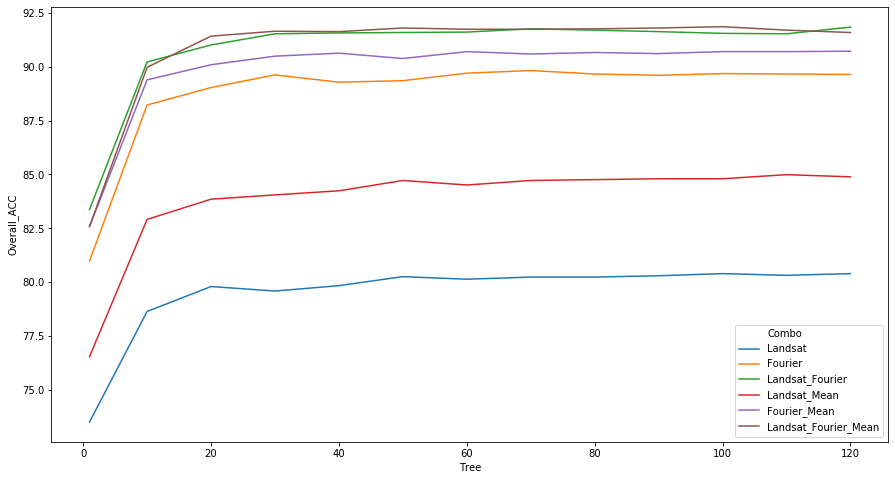

In [66]:
plt.figure(figsize=(15,8))
sns.lineplot(data = Landsat_5,x = 'Tree',y='Overall_ACC',hue='Combo')

<Figure size 720x432 with 0 Axes>

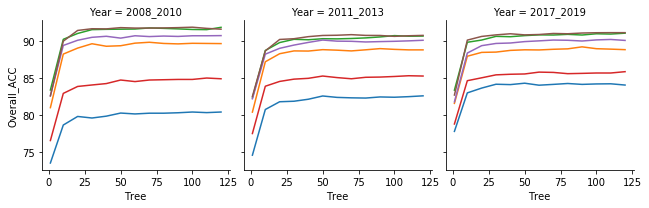

In [61]:
plt.figure(figsize=(10,6))
fig = sns.FacetGrid(data = Full_Percent,col = 'Year',hue='Combo')
fig.map(sns.lineplot,'Tree','Overall_ACC')

In [15]:
Combo_acc_df

,Year,Combo,Percent,Tree,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,2017_2019,Landsat,0,1,86.76,91.68,49.72,93.21,44.22
1,2017_2019,Landsat,0,10,91.26,92.54,77.02,97.83,47.99
2,2017_2019,Landsat,0,20,91.46,92.92,76.32,97.60,51.01
3,2017_2019,Landsat,0,30,91.46,93.05,75.55,97.45,52.01
4,2017_2019,Landsat,0,40,91.26,92.97,74.28,97.29,51.51
...,...,...,...,...,...,...,...,...,...
2803,2008_2010,Landsat_Fourier_Mean,100,80,94.18,91.97,96.49,96.48,92.00
2804,2008_2010,Landsat_Fourier_Mean,100,90,94.24,92.07,96.50,96.48,92.11
2805,2008_2010,Landsat_Fourier_Mean,100,100,94.24,92.01,96.57,96.55,92.03
2806,2008_2010,Landsat_Fourier_Mean,100,110,94.20,91.94,96.56,96.55,91.96


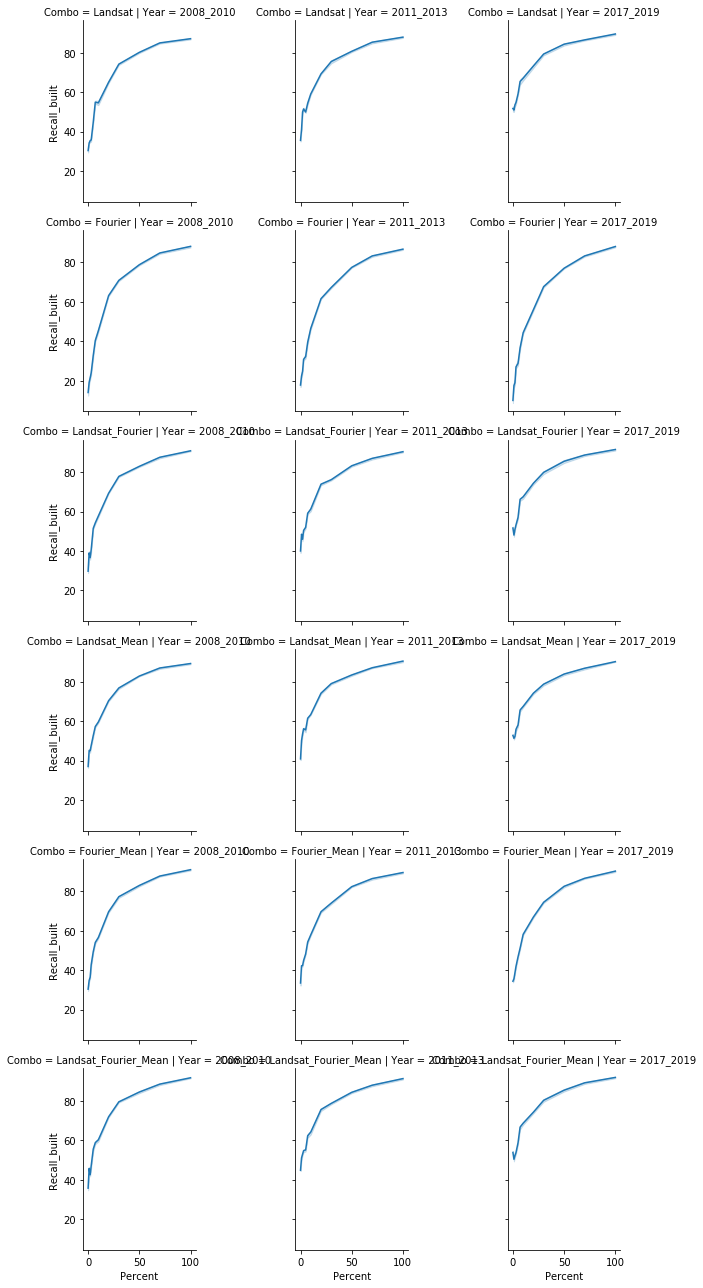

In [14]:
g = sns.FacetGrid(data = Combo_acc_df,row = 'Combo',col='Year')
g.map(sns.lineplot,'Percent','Recall_built')